In [37]:
import pandas as pd
import ipfn
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

## Load Data

In [505]:
# Read in individual data
inds = pd.read_csv('../data/London_inds.csv',index_col=0)
inds.head()

,pidp,sex,age_6cat,eth_5cat,employ,worktrav,caruse,cycleuse,sex_age_eth
0,22445,f,25-34,White,Employed,Public,Car,Bike,f25_34White
1,29925,f,35-44,White,SelfEmployed,Car,Car,NoBike,f35_44White
2,2853965,f,25-34,White,Employed,Public,NoCar,Bike,f25_34White
3,68002725,f,55-64,Asian,Employed,inapplicable,NoCar,NoBike,f55_64Asian
4,68021765,f,55-64,Black,Employed,Car,Car,Bike,f55_64Black


In [506]:
# As we'll use worktrav as a constraint, we'll have to remove the individuals with missing (n=)
inds = inds.drop(inds[inds['worktrav'] == 'missing'].index)
# reindex
inds.reset_index(drop=True,inplace=True)
len(inds)

6081

In [95]:
# Read in constraints data
cons = pd.read_csv('../data/WF_cons.csv',index_col=0)
cons.head()

,GEO_CODE,f16_24Asian,f16_24Black,f16_24Mixed,f16_24Other,f16_24White,f25_34Asian,f25_34Black,f25_34Mixed,f25_34Other,...,m65_74Other,m65_74White,Employed,SelfEmployed,NotEmployed,Car,Public,Cycle,Walk,inapplicable
0,E05000590,194,243,69,35,311,301,264,57,42,...,7,139,4441,1377,4565,1539,3788,185,348,4523
1,E05000591,231,300,76,28,311,366,284,44,75,...,8,127,4105,1149,4374,1200,3785,145,291,4207
2,E05000592,145,179,76,20,361,279,186,51,75,...,6,189,5085,1360,3697,2243,3234,197,446,4022
3,E05000593,23,39,35,9,389,54,44,26,9,...,6,457,3643,961,2651,2228,1714,50,212,3051
4,E05000594,53,72,41,22,425,76,44,25,25,...,5,389,3922,975,2972,2652,1614,55,225,3323


In [117]:
# Create ind dataframe to match constraints table for verification etc.
# First make a dataframe of zeros with the same fields as cons
ind_catr = pd.DataFrame(np.zeros(shape=(len(inds),len(cons.columns[1:]))), columns=cons.columns[1:])
# Now iterate through the inds file and update the binary table as required.
for idx,row in inds.iterrows():
    # Update sex_age_eth
    ind_catr.loc[idx,row['sex_age_eth']] = 1
    # update employ
    ind_catr.loc[idx,row['employ']] = 1
    # update worktrav
    ind_catr.loc[idx,row['worktrav']] = 1
ind_catr.head()

,f16_24Asian,f16_24Black,f16_24Mixed,f16_24Other,f16_24White,f25_34Asian,f25_34Black,f25_34Mixed,f25_34Other,f25_34White,...,m65_74Other,m65_74White,Employed,SelfEmployed,NotEmployed,Car,Public,Cycle,Walk,inapplicable
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Iterative Proportional Fitting #1
One dimensionsal on sex-age-ethnicity, gives a perfect fit on contraints.

In [108]:
# 1d iterative proportional fitting on sex_age_eth
weights = np.ones((len(inds),len(cons))) # weights matrix, 6081 individuals (rows) x 20 wards (columns)

# Overal marginal distribution of individuals by constraints
ind_agg = ind_catr.sum(axis=0)
# marginal distribution of indivuals by zone
ind_agg_zone = cons.drop('GEO_CODE',axis=1).apply(lambda x: 1.0*ind_agg, axis=1)

categories = cons.columns[1:61]

for i in range(0,len(cons)):
    for j in categories:
        index = ind_catr.loc[:,j] == 1
        weights[index,i] = (weights[index, i] * cons.loc[i,j]) / ind_agg_zone.loc[i, j]


In [109]:
ind_agg_weight = (ind_agg_zone * np.nan).copy()
for i in range(0,len(cons)):
    ind_agg_weight.iloc[i] = ind_catr.apply(lambda x: x*weights[:,i],axis=0).sum(axis=0)

In [114]:
np.corrcoef(ind_agg_weight.values[:,range(0,60)].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)].ravel())[0,1]

1.0

## Iterative Proportional Fitting #2
Two dimensional on age-sex-ethnicity and employment as employed, self-employed, not employed. 
Slightly less than perfect fit. This likely arises due to the non-representation of self-employed people for some sex-age-ethnicity categories. We chack this in the next model.

In [115]:
ind_cat = inds[['sex_age_eth','employ']].copy()

for i in range(0,len(cons)):
    # Make weights column for zone i
    ind_cat['weight_' + cons.iloc[i]['GEO_CODE']] = np.ones(len(ind_cat))
    
    # Now get the aggregates (marginals) for zone 1 for age and sex.
    sex_age_eth = cons.iloc[i,range(1,61)]
    employ = cons.iloc[i,range(61,64)]
    
    aggregates = [sex_age_eth,employ]
    dimensions = [['sex_age_eth'],['employ']]

    # Do iterative proportional fitting
    ipf = ipfn.ipfn(ind_cat, aggregates, dimensions, weight_col='weight_'+cons.iloc[i]['GEO_CODE'],convergence_rate = 1e-15)
    ind_cat = ipf.iteration()

ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: conv

In [159]:
ind_agg_weight = (ind_agg_zone * np.nan).copy()

# check fit
for i in range(0,len(cons)):
    ward = cons.iloc[i]['GEO_CODE']
    ind_agg_weight.iloc[i] = ind_catr.apply(lambda x: x*ind_cat['weight_' + ward],axis=0).sum(axis=0)
# Check the goodness of fit
np.corrcoef(ind_agg_weight.values[:,range(0,63)].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,63)].ravel())[0,1]

0.99910025258041846

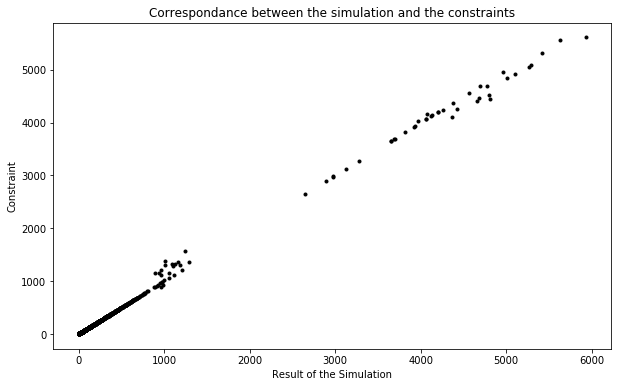

In [173]:
f, ax = plt.subplots(figsize=(10,6))

ax.scatter(ind_agg_weight.values[:,range(0,63)].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,63)].ravel(),marker='.',color='k')
ax.set_xlabel('Result of the Simulation')
ax.set_ylabel('Constraint')
ax.set_title('Correspondance between the simulation and the constraints');

## Iterative Proportional Fitting #3
Two dimensional on age-sex-ethnicity and employment as (employed + self-employed), not employed. 
Perfect fit on weights. As it's not clear whether dividing employed and self-employed offers much, I'll move forwards with this.

In [137]:
ind_cat = inds[['sex_age_eth','employ']].copy()
# Recode employ to combine Employed and SelfEmployed
ind_cat['employ2'] = ind_cat['employ'].apply(lambda x: 'Employ2' if x in ['Employed','SelfEmployed'] else 'NotEmployed')

# Make combined Employed and Self-Employed marginal totals
cons['Employ2'] = cons[['Employed','SelfEmployed']].sum(axis=1)

for i in range(0,len(cons)):
    # Make weights column for zone i
    ind_cat['weight_' + cons.iloc[i]['GEO_CODE']] = np.ones(len(ind_cat))
    
    # Now get the aggregates (marginals) for zone 1 for age and sex.
    sex_age_eth = cons.iloc[i,range(1,61)]
    employ = cons.iloc[i,[69,63]]
    
    aggregates = [sex_age_eth,employ]
    dimensions = [['sex_age_eth'],['employ2']]

    # Do iterative proportional fitting
    ipf = ipfn.ipfn(ind_cat, aggregates, dimensions, weight_col='weight_'+cons.iloc[i]['GEO_CODE'],convergence_rate = 1e-15)
    ind_cat = ipf.iteration()

ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: conv

In [170]:
# Overal marginal distribution of individuals by constraints
ind_agg = ind_catr.sum(axis=0)
# Manually add employed + self-employed value
ind_agg = ind_agg.append(pd.Series([3565],index=['Employ2']))
# marginal distribution of individuals by zone
ind_agg_zone = cons.drop('GEO_CODE',axis=1).apply(lambda x: 1.0*ind_agg, axis=1)
# Add employ2 to ind_catr
ind_catr['Employ2'] = ind_catr[['Employed','SelfEmployed']].sum(axis=1)

ind_agg_weight = (ind_agg_zone * np.nan).copy()

# check fit
for i in range(0,len(cons)):
    ward = cons.iloc[i]['GEO_CODE']
    ind_agg_weight.iloc[i] = ind_catr.apply(lambda x: x*ind_cat['weight_' + ward],axis=0).sum(axis=0)
# Check the goodness of fit
np.corrcoef(ind_agg_weight.values[:,range(0,60)+[68,62]].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)+[68,62]].ravel())[0,1]

1.0

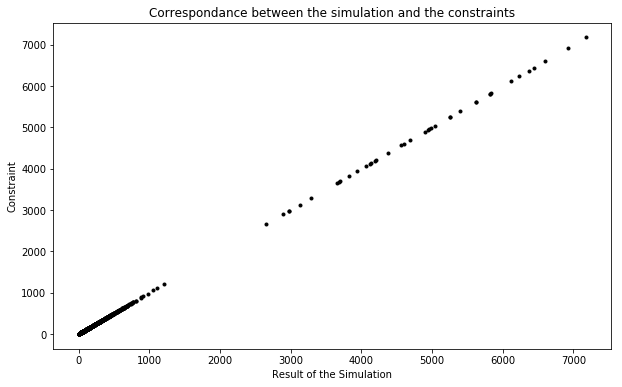

In [172]:
f, ax = plt.subplots(figsize=(10,6))

ax.scatter(ind_agg_weight.values[:,range(0,60)+[68,62]].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)+[68,62]].ravel(),marker='.',color='k')
ax.set_xlabel('Result of the Simulation')
ax.set_ylabel('Constraint')
ax.set_title('Correspondance between the simulation and the constraints');

## Iterative Proportional Fitting #4
Two dimensional on age-sex-ethnicity and travel to work. NB travel to work responses basically proxy employment anyway.
Fit is near perfect, and contains important info on commute mode.

In [195]:
# Inapplicable captures both people that aren't employed (94% of Not Employed) and people that work at home (14% of Employed)
# The 6% of notemployed people who responded to worktrav may be students, but ultimately this is unclear.
# Taken together people responding to worktrav could be thought of a self-identified 'commuters' of one sort or another.
pd.crosstab(ind_cat['employ2'],inds['worktrav'])

worktrav,Car,Cycle,Public,Walk,inapplicable
employ2,,,,,
Employ2,1110,145,1579,300,431
NotEmployed,43,4,80,17,2372


In [245]:
ind_cat = inds[['sex_age_eth','worktrav']].copy()

for i in range(0,len(cons)):
    # Make weights column for zone i
    ind_cat['weight_' + cons.iloc[i]['GEO_CODE']] = np.ones(len(ind_cat))
    
    # Now get the aggregates (marginals) for zone 1 for age and sex.
    sex_age_eth = cons.iloc[i,range(1,61)]
    worktrav =  cons.iloc[i,[64,65,66,67,68]]
    
    aggregates = [sex_age_eth,worktrav]
    dimensions = [['sex_age_eth'],['worktrav']]

    # Do iterative proportional fitting
    ipf = ipfn.ipfn(ind_cat, aggregates, dimensions, weight_col='weight_'+cons.iloc[i]['GEO_CODE'],convergence_rate = 1e-15)
    ind_cat = ipf.iteration()

ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: conv

In [246]:
ind_agg_weight = (ind_agg_zone * np.nan).copy()

# check fit
for i in range(0,len(cons)):
    ward = cons.iloc[i]['GEO_CODE']
    ind_agg_weight.iloc[i] = ind_catr.apply(lambda x: x*ind_cat['weight_' + ward],axis=0).sum(axis=0)
# Check the goodness of fit
np.corrcoef(ind_agg_weight.values[:,range(0,60)+[63,64,65,66,67]].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)+[63,64,65,66,67]].ravel())[0,1]

0.99999999999999978

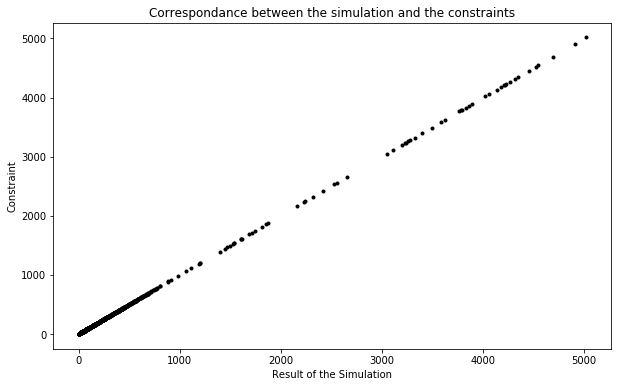

In [247]:
f, ax = plt.subplots(figsize=(10,6))

ax.scatter(ind_agg_weight.values[:,range(0,60)+[63,64,65,66,67]].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)+[63,64,65,66,67]].ravel(),marker='.',color='k')
ax.set_xlabel('Result of the Simulation')
ax.set_ylabel('Constraint')
ax.set_title('Correspondance between the simulation and the constraints');

## Iterative Proportional Fitting #5
Three dimensional on sex-age-ethnicity, employment (2 category) and commute mode. Might be overfitting though or lacking some particular 3-way crosstabs, evidenced by the poor fit.

In [189]:
ind_cat = inds[['sex_age_eth','employ','worktrav']].copy()
# Recode employ to combine Employed and SelfEmployed
ind_cat['employ2'] = ind_cat['employ'].apply(lambda x: 'Employ2' if x in ['Employed','SelfEmployed'] else 'NotEmployed')

# Make combined Employed and Self-Employed marginal totals
cons['Employ2'] = cons[['Employed','SelfEmployed']].sum(axis=1)

for i in range(0,len(cons)):
    # Make weights column for zone i
    ind_cat['weight_' + cons.iloc[i]['GEO_CODE']] = np.ones(len(ind_cat))
    
    # Now get the aggregates (marginals) for zone 1 for age and sex.
    sex_age_eth = cons.iloc[i,range(1,61)]
    employ = cons.iloc[i,[69,63]]
    worktrav =  cons.iloc[i,[64,65,66,67,68]]
    
    aggregates = [sex_age_eth,worktrav,employ]
    dimensions = [['sex_age_eth'],['worktrav'],['employ2']]

    # Do iterative proportional fitting
    ipf = ipfn.ipfn(ind_cat, aggregates, dimensions, weight_col='weight_'+cons.iloc[i]['GEO_CODE'],convergence_rate = 1e-15)
    ind_cat = ipf.iteration()

ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: convergence_rate not updating or below rate_tolerance
ipfn converged: conv

In [191]:
ind_agg_weight = (ind_agg_zone * np.nan).copy()

# check fit
for i in range(0,len(cons)):
    ward = cons.iloc[i]['GEO_CODE']
    ind_agg_weight.iloc[i] = ind_catr.apply(lambda x: x*ind_cat['weight_' + ward],axis=0).sum(axis=0)
# Check the goodness of fit
np.corrcoef(ind_agg_weight.values[:,range(0,60)+[63,64,65,66,67]+[68,62]].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)+[64,65,66,67,68]+[68,62]].ravel())[0,1]

0.82864909994840885

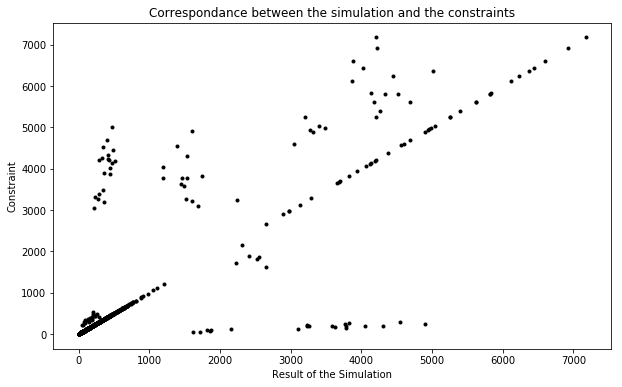

In [193]:
f, ax = plt.subplots(figsize=(10,6))

ax.scatter(ind_agg_weight.values[:,range(0,60)+[68,62]+[63,64,65,66,67]].ravel(),cons.drop('GEO_CODE',axis=1).values[:,range(0,60)+[68,62]+[64,65,66,67,68]].ravel(),marker='.',color='k')
ax.set_xlabel('Result of the Simulation')
ax.set_ylabel('Constraint')
ax.set_title('Correspondance between the simulation and the constraints');

## Integerisation and Expansion
Using 2D sex-age-eth and worktrav. 

In [248]:
# Truncate, replicate, sample 'TRS' integerisation approach.
def int_trs(weights):
    # convert to a vector if required
    xv = np.array(weights).ravel()
    # truncate - just get the integer part of the weight
    xint = np.floor(xv)
    # Get the decimal bit of the weight
    r = xv - xint
    # Work out the deficit population
    frac_sum = round(r.sum())
    # Sample based upon the deficit bit
    xs = np.random.choice(len(xv),int(frac_sum),True,r/r.sum())
    # Get the result of the deficit part
    topup = np.bincount(xs,minlength=len(xv))
    return xint + topup

def int_expand_vector(weights):
    return np.repeat(range(0,len(weights)),weights.astype(int))

In [439]:
indivs = []
for i in range(0,len(cons)):
    ward = cons.iloc[i]['GEO_CODE']
    # Integerise and expand - gives a list of the ind ids for the ward
    ints = int_expand_vector(int_trs(ind_cat['weight_'+ ward]))
    # Select the relevant individuals and cols
    temp = inds.iloc[ints][['pidp','sex','age_6cat','eth_5cat','employ','worktrav','caruse','cycleuse']]
    temp['ward'] = ward
    indivs.append(temp)
ints_df = pd.concat(indivs)
ints_df.reset_index(inplace=True)
ints_df.head()

,index,pidp,sex,age_6cat,eth_5cat,employ,worktrav,caruse,cycleuse,ward
0,0,22445,f,25-34,White,Employed,Public,Car,Bike,E05000590
1,0,22445,f,25-34,White,Employed,Public,Car,Bike,E05000590
2,0,22445,f,25-34,White,Employed,Public,Car,Bike,E05000590
3,1,29925,f,35-44,White,SelfEmployed,Car,Car,NoBike,E05000590
4,2,2853965,f,25-34,White,Employed,Public,NoCar,Bike,E05000590


## Basic Checks
Overall, simulated vs. observed differences are relatively small on constraints, suggesting a decent model.

In [333]:
# sex
# We would expect the constraint variables to be pretty much exact.
# Looks good, slight variation is due to the integerisation process.
print "simulation male", ints_df['sex'].value_counts(normalize=True)['m']
print "observed male", cons[cons.columns[cons.columns.str.contains(r'[m][0-9]')]].sum(axis=1).sum()/float(cons[['Employ2','NotEmployed']].sum(axis=1).sum())

simulation male 0.503162667951
observed male 0.502413890605


In [363]:
# sex by ward - differences are all less than 5% difference.
male_cons = (cons[cons.columns[cons.columns.str.contains(r'[m][0-9]')]].sum(axis=1)/cons[['Employ2','NotEmployed']].sum(axis=1)).to_frame()
male_cons.rename(columns={0:'obs_male'},inplace=True)
male_inds = pd.melt(ints_df.groupby('ward')['sex'].value_counts(normalize=True).to_frame()).iloc[range(0,39,2)].reset_index(drop=True)
male_inds.rename(columns={'value':'sim_male'},inplace=True)
sex_compare = male_inds.merge(male_cons.merge(cons['GEO_CODE'].to_frame(),left_index=True,right_index=True),left_index=True,right_index=True)
sex_compare['diff'] = abs(sex_compare['sim_male']-sex_compare['obs_male'])
sex_compare

,variable,sim_male,obs_male,GEO_CODE,diff
0,sex,0.535876,0.532987,E05000590,0.002889
1,sex,0.508828,0.504778,E05000591,0.004051
2,sex,0.504043,0.499901,E05000592,0.004141
3,sex,0.506961,0.485320,E05000593,0.021640
4,sex,0.512009,0.487610,E05000594,0.024400
5,sex,0.523239,0.519314,E05000595,0.003925
6,sex,0.520738,0.522320,E05000596,0.001582
7,sex,0.526316,0.476751,E05000597,0.049564
8,sex,0.525924,0.476221,E05000598,0.049704
9,sex,0.541329,0.538384,E05000599,0.002946


In [422]:
# age - looks to be in the right ballpark overall
print "Simulated age counts"
print ints_df['age_6cat'].value_counts(normalize=True).sort_index()


ages = ['16_24','25_34','35_44','45_54','55_64','65_74']
age_df = [cons['GEO_CODE']]
for age in ages:
    age_df.append(pd.Series(cons[cons.columns[cons.columns.str.contains(r'[m,f]' + age)]].sum(axis=1),name=age))

age_df = pd.concat(age_df,axis=1)
age_df['total'] = age_df[age_df.columns[1:]].sum(axis=1)
print ""
print "Observed age counts"
print age_df[age_df.columns[1:-1]].sum(axis=0)/age_df[age_df.columns[1:-1]].sum(axis=0).sum()

Simulated age counts
16-24    0.172198
25-34    0.265020
35-44    0.216836
45-54    0.165108
55-64    0.110007
65-74    0.070830
Name: age_6cat, dtype: float64

Observed age counts
16_24    0.171690
25_34    0.265350
35_44    0.216543
45_54    0.165783
55_64    0.110400
65_74    0.070233
dtype: float64


In [421]:
# age by ward - percentage errors are small, and less than 1% in all cases.
age_inds = ints_df.groupby('ward')['age_6cat'].value_counts(normalize=True).sort_index().unstack()
age_df = age_df.merge(age_inds,left_on = 'GEO_CODE',right_index=True)
cols = []
for age in ages:
    cols.append('per_err_' + age)
    age_df['per_err_' + age] = age_df.apply(lambda x: abs((x[age]/float(x['total']) - x[age.replace('_','-')])*100.0) , axis=1)

age_df[cols]

,per_err_16_24,per_err_25_34,per_err_35_44,per_err_45_54,per_err_55_64,per_err_65_74
0,0.096311,0.317827,0.192623,0.077049,0.182991,0.346721
1,0.207727,0.062318,0.519319,0.529705,0.135023,0.124636
2,0.049300,0.098600,0.039440,0.325380,0.364820,0.147900
3,0.358374,0.206754,0.124052,0.234321,0.068918,0.110269
4,0.470200,0.292286,0.038124,0.139789,0.304994,0.228746
5,0.330510,0.289196,0.051642,0.165255,0.165255,0.092956
6,0.017575,0.166960,0.026362,0.096661,0.052724,0.254833
7,0.429395,0.687032,0.110416,0.110416,0.269906,0.012268
8,0.466759,0.832597,0.340608,0.302763,0.025230,0.302763
9,0.294551,0.046024,0.285346,0.331370,0.276141,0.000000


In [425]:
# ethnicity - looks to be in the right ballpark overall
print "Simulated Ethnicity counts"
print ints_df['eth_5cat'].value_counts(normalize=True).sort_index()

eths = ['Asian','Black','Mixed','Other','White']
eth_df = [cons['GEO_CODE']]
for eth in eths:
    eth_df.append(pd.Series(cons[cons.columns[cons.columns.str.contains(eth)]].sum(axis=1),name=eth))

eth_df = pd.concat(eth_df,axis=1)
eth_df['total'] = eth_df[eth_df.columns[1:]].sum(axis=1)
print ""
print "Observed Ethnicity counts"
print eth_df[eth_df.columns[1:-1]].sum(axis=0)/eth_df[eth_df.columns[1:-1]].sum(axis=0).sum()

Simulated Ethnicity counts
Asian    0.208537
Black    0.165548
Mixed    0.036067
Other    0.040711
White    0.549137
Name: eth_5cat, dtype: float64

Observed Ethnicity counts
Asian    0.208726
Black    0.165490
Mixed    0.036360
Other    0.040659
White    0.548765
dtype: float64


In [429]:
# ethnicity by ward. All errors less than 0.5%
eth_inds = ints_df.groupby('ward')['eth_5cat'].value_counts(normalize=True).sort_index().unstack()
eth_df = eth_df.merge(eth_inds,left_on = 'GEO_CODE',right_index=True)

cols = []
for eth in eths:
    cols.append('per_err_' + eth)
    eth_df['per_err_' + eth] = eth_df.apply(lambda x: abs((x[eth  +"_x"]/float(x['total']) - x[eth  +"_y"])*100.0) , axis=1)

eth_df[cols]

,per_err_Asian,per_err_Black,per_err_Mixed,per_err_Other,per_err_White
0,0.288934,0.182991,0.009631,0.019262,0.443032
1,0.249273,0.321978,0.093477,0.083091,0.103864
2,0.019720,0.059160,0.108460,0.039440,0.108460
3,0.027567,0.137836,0.179187,0.027567,0.261888
4,0.101665,0.177913,0.216038,0.063540,0.127081
5,0.247883,0.000000,0.134270,0.227226,0.113613
6,0.202109,0.333919,0.079086,0.035149,0.175747
7,0.257637,0.098147,0.036805,0.282174,0.404858
8,0.100921,0.340608,0.075691,0.037845,0.353223
9,0.156480,0.174890,0.101252,0.073638,0.046024


In [433]:
# Mode of travel to work. - looks decent
print "Simulated work travel mode counts"
print ints_df['worktrav'].value_counts(normalize=True).sort_index()

modes = ['Car','Cycle','Public','Walk','inapplicable']
trav_df = [cons['GEO_CODE']]
for mode in modes:
    trav_df.append(pd.Series(cons[cons.columns[cons.columns.str.contains(mode)]].sum(axis=1),name=mode))

trav_df = pd.concat(trav_df,axis=1)
trav_df['total'] = trav_df[trav_df.columns[1:]].sum(axis=1)
print ""
print "Observed work travel mode counts"
print trav_df[trav_df.columns[1:-1]].sum(axis=0)/trav_df[trav_df.columns[1:-1]].sum(axis=0).sum()

Simulated work travel mode counts
Car             0.191629
Cycle           0.017075
Public          0.334211
Walk            0.039308
inapplicable    0.417776
Name: worktrav, dtype: float64

Observed work travel mode counts
Car             0.190399
Cycle           0.017311
Public          0.335431
Walk            0.039272
inapplicable    0.417587
dtype: float64


In [434]:
# mode of travel to work by ward. All errors less than 1.3%
trav_inds = ints_df.groupby('ward')['worktrav'].value_counts(normalize=True).sort_index().unstack()
trav_df = trav_df.merge(trav_inds,left_on = 'GEO_CODE',right_index=True)

cols = []
for mode in modes:
    cols.append('per_err_' + mode)
    trav_df['per_err_' + mode] = trav_df.apply(lambda x: abs((x[mode  +"_x"]/float(x['total']) - x[mode  +"_y"])*100.0) , axis=1)

trav_df[cols]

,per_err_Car,per_err_Cycle,per_err_Public,per_err_Walk,per_err_inapplicable
0,0.144467,0.028893,0.192623,0.115574,0.192623
1,0.259659,0.051932,0.342750,0.010386,0.041545
2,0.305660,0.078880,0.256360,0.108460,0.078880
3,0.813232,0.124052,1.295658,0.055134,0.303239
4,0.419367,0.076249,0.317702,0.343119,0.317702
5,0.444123,0.061971,0.247883,0.000000,0.258211
6,0.105448,0.017575,0.193322,0.052724,0.158172
7,0.429395,0.012268,0.306711,0.036805,0.073611
8,0.416299,0.025230,0.441529,0.063076,0.012615
9,0.018409,0.036819,0.220913,0.064433,0.303756


## Estimates

In [440]:
# The current model overpredicts not employed by c.10%
# This is probably due to the working from home distinction inherent in being inapplicable for travel to work.
print "Simulation employment"
print ints_df['employ'].value_counts(normalize=True)

emps = ['Employed','NotEmployed','SelfEmployed']
emp_df = [cons['GEO_CODE']]
for emp in emps:
    emp_df.append(pd.Series(cons[cons.columns[cons.columns.str.contains(emp)]].sum(axis=1),name=emp))

emp_df = pd.concat(emp_df,axis=1)
emp_df['total'] = emp_df[emp_df.columns[1:]].sum(axis=1)
print ""
print "Observed Ethnicity counts"
print emp_df[emp_df.columns[1:-1]].sum(axis=0)/emp_df[emp_df.columns[1:-1]].sum(axis=0).sum()

Simulation employment
Employed        0.522846
NotEmployed     0.365498
SelfEmployed    0.111657
Name: employ, dtype: float64

Observed Ethnicity counts
Employed        0.657000
NotEmployed     0.261502
SelfEmployed    0.081498
dtype: float64


In [250]:
# Access to a car or van comes in a roughly 50-50
ints_df['caruse'].value_counts(normalize=True)

NoCar    0.502314
Car      0.497686
Name: caruse, dtype: float64

In [442]:
# Car access by ward. Clear variation in predicted access to car by ward. High = 61% low = 43%.
ints_df.groupby('ward')['caruse'].value_counts(normalize=True).sort_index()

ward       caruse
E05000590  Car       0.442839
           NoCar     0.557161
E05000591  Car       0.432385
           NoCar     0.567615
E05000592  Car       0.512424
           NoCar     0.487576
E05000593  Car       0.614748
           NoCar     0.385252
E05000594  Car       0.602745
           NoCar     0.397255
E05000595  Car       0.468292
           NoCar     0.531708
E05000596  Car       0.465378
           NoCar     0.534622
E05000597  Car       0.559686
           NoCar     0.440314
E05000598  Car       0.597452
           NoCar     0.402548
E05000599  Car       0.467507
           NoCar     0.532493
E05000600  Car       0.483596
           NoCar     0.516404
E05000601  Car       0.461487
           NoCar     0.538513
E05000602  Car       0.588646
           NoCar     0.411354
E05000603  Car       0.466508
           NoCar     0.533492
E05000604  Car       0.440597
           NoCar     0.559403
E05000605  Car       0.468170
           NoCar     0.531830
E05000606  Car       0

## Predicting bicycle access
We have a slight issue with bicycle access, as the ethnic boost part of the survey wasn't asked about travel behaviours. However, we really need those people to have enough people from ethnic minority populations to create a reasonable synthetic population. This means that 1/3 of the synthetic population has missing on bicycle access.

Therefore, we'll try to model the conditional probability of having bicycle access using the complete case data, and then randomly assign bicycle acccess based on those probabilities to the people who are missing.

In [444]:
# There is a lot of missing on bike use because the ethnic boost don't get asked the question.
ints_df['cycleuse'].value_counts(normalize=True)

missing    0.363529
NoBike     0.345501
Bike       0.290971
Name: cycleuse, dtype: float64

In [448]:
cycle = inds[inds['cycleuse'] != 'missing'] # dataset of 3,893 people.

In [452]:
# cycling is a binary outcome, so we'll use a logistic regression.
from statsmodels.discrete.discrete_model import Logit

# recode outcome (cycling) to binary
cycle['cycle'] = cycle['cycleuse'].apply(lambda x: 1 if x == 'Bike' else 0)

C:\Users\ppehdlew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [453]:
# Much more likely to have access to a bicycle if male compared to female (OR: 1.92 - almost twice as likely.)
res = Logit.from_formula('cycle~sex',data=cycle).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.667219
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 3893
Model:                          Logit   Df Residuals:                     3891
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Aug 2018   Pseudo R-squ.:                 0.01861
Time:                        17:09:36   Log-Likelihood:                -2597.5
converged:                       True   LL-Null:                       -2646.7
                                        LLR p-value:                 3.261e-23
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6180      0.045    -13.860      0.000      -0.705      -0.531
sex[T.m]       0.6525      0.066      9.875      0.000       0.523       0.782
==============================================================================
"""

In [457]:
# Much more likely to have access to a bicycle if younger
res = Logit.from_formula('cycle~age_6cat',data=cycle).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.671071
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 3893
Model:                          Logit   Df Residuals:                     3887
Method:                           MLE   Df Model:                            5
Date:                Thu, 16 Aug 2018   Pseudo R-squ.:                 0.01294
Time:                        17:16:40   Log-Likelihood:                -2612.5
converged:                       True   LL-Null:                       -2646.7
                                        LLR p-value:                 2.102e-13
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0222      0.080      0.279      0.781      -0.134       0.178
age_6cat[T.25-34]    -0.3513      0.113     -3.122      0.002      -0.572      -0.131
age_6cat[T.35-44]    -0.3382      0.107     -3.162      0.002      -0.548      -0.129
age_6cat[T.45-54]    -0.1745      0.105     -1.661      0.097      -0.381       0.031
age_6cat[T.55-64]    -0.6698      0.120     -5.598      0.000      -0.904      -0.435
age_6cat[T.65-74]    -0.9314      0.137     -6.821      0.000      -1.199      -0.664
=====================================================================================
"""

In [465]:
# Much more likely to have access to a bicycle if White, less likely if Asian, Other
res = Logit.from_formula('cycle~eth_5cat',data=cycle).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.659838
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 3893
Model:                          Logit   Df Residuals:                     3888
Method:                           MLE   Df Model:                            4
Date:                Thu, 16 Aug 2018   Pseudo R-squ.:                 0.02946
Time:                        17:24:25   Log-Likelihood:                -2568.8
converged:                       True   LL-Null:                       -2646.7
                                        LLR p-value:                 1.075e-32
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.8424      0.064    -13.195      0.000      -0.968      -0.717
eth_5cat[T.Black]     0.2896      0.099      2.924      0.003       0.095       0.484
eth_5cat[T.Mixed]     0.7006      0.148      4.738      0.000       0.411       0.990
eth_5cat[T.Other]     0.2575      0.210      1.227      0.220      -0.154       0.669
eth_5cat[T.White]     0.9413      0.081     11.656      0.000       0.783       1.100
=====================================================================================
"""

In [466]:
cycle['employ2'] = cycle['employ'].apply(lambda x: 'Employed' if x != 'NotEmployed' else 'NotEmployed')

# Much more likely to have access to a bicycle if employed
res = Logit.from_formula('cycle~employ2',data=cycle).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.673338
         Iterations 4


C:\Users\ppehdlew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 3893
Model:                          Logit   Df Residuals:                     3891
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Aug 2018   Pseudo R-squ.:                0.009606
Time:                        17:24:54   Log-Likelihood:                -2621.3
converged:                       True   LL-Null:                       -2646.7
                                        LLR p-value:                 9.967e-13
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.1422      0.041     -3.430      0.001      -0.224      -0.061
employ2[T.NotEmployed]    -0.4775      0.067     -7.081      0.000      -0.610      -0.345
==========================================================================================
"""

In [472]:
# More likely to have access to a bicycle if have access to a car
res = Logit.from_formula('cycle~caruse',data=cycle).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.676093
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 3893
Model:                          Logit   Df Residuals:                     3891
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Aug 2018   Pseudo R-squ.:                0.005554
Time:                        17:39:25   Log-Likelihood:                -2632.0
converged:                       True   LL-Null:                       -2646.7
                                        LLR p-value:                 5.887e-08
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1677      0.044     -3.832      0.000      -0.253      -0.082
caruse[T.NoCar]    -0.3548      0.066     -5.406      0.000      -0.483      -0.226
===================================================================================
"""

In [474]:
# Fully adjusted model
cycle_model = Logit.from_formula('cycle~sex+age_6cat+eth_5cat+employ2+caruse',data=cycle).fit()
cycle_model.summary()

Optimization terminated successfully.
         Current function value: 0.628420
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  cycle   No. Observations:                 3893
Model:                          Logit   Df Residuals:                     3880
Method:                           MLE   Df Model:                           12
Date:                Thu, 16 Aug 2018   Pseudo R-squ.:                 0.07567
Time:                        17:40:59   Log-Likelihood:                -2446.4
converged:                       True   LL-Null:                       -2646.7
                                        LLR p-value:                 2.851e-78
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.3374      0.131     -2.567      0.010      -0.595      -0.080
sex[T.m]                   0.6293      0.070      9.000      0.000       0.492       0.766
age_6cat[T.25-34]         -0.6074      0.124     -4.902      0.000      -0.850      -0.365
age_6cat[T.35-44]         -0.6390      0.121     -5.276      0.000      -0.876      -0.402
age_6cat[T.45-54]         -0.5243      0.119     -4.408      0.000      -0.757      -0.291
age_6cat[T.55-64]         -1.0981      0.132     -8.326      0.000      -1.357      -0.840
age_6cat[T.65-74]         -1.4200      0.152     -9.356      0.000      -1.717      -1.123
eth_5cat[T.Black]          0.3875      0.104      3.729      0.000       0.184       0.591
eth_5cat[T.Mixed]          0.7066      0.153      4.632      0.000       0.408       1.006
eth_5cat[T.Other]          0.3342      0.217      1.543      0.123      -0.090       0.759
eth_5cat[T.White]          1.0807      0.086     12.544      0.000       0.912       1.250
employ2[T.NotEmployed]    -0.1947      0.082     -2.366      0.018      -0.356      -0.033
caruse[T.NoCar]           -0.3360      0.077     -4.378      0.000      -0.486      -0.186
==========================================================================================
"""

In [480]:
# Now get the people with missing on cycleuse
missing = inds[inds['cycleuse'] == 'missing']
# derive employ2 variable
missing['employ2'] = missing['employ'].apply(lambda x: 'Employed' if x != 'NotEmployed' else 'NotEmployed')

# Get the predicted probabilities
missing['prob_cycle'] = cycle_model.predict(missing)
missing.head()

C:\Users\ppehdlew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\ppehdlew\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,pidp,sex,age_6cat,eth_5cat,employ,worktrav,caruse,cycleuse,sex_age_eth,employ2,prob_cycle
6,68021781,m,16-24,Black,NotEmployed,inapplicable,NoCar,missing,m16_24Black,NotEmployed,0.537128
50,68912575,m,16-24,White,NotEmployed,inapplicable,NoCar,missing,m16_24White,NotEmployed,0.698865
66,68945891,f,16-24,White,NotEmployed,inapplicable,Car,missing,f16_24White,NotEmployed,0.633809
124,69833965,m,65-74,White,NotEmployed,inapplicable,NoCar,missing,m65_74White,NotEmployed,0.359369
126,69833977,m,25-34,White,NotEmployed,inapplicable,NoCar,missing,m25_34White,NotEmployed,0.558356


In [515]:
# Now, for each missing in the synthetic data, find the predicted probability of that person and randomly allocate.
updates = []
for idx, row in ints_df.iterrows():
    if row['cycleuse'] == 'missing':
        #Get pidp
        pidp = row['pidp']
        # get predicted probability of cycle access from missing table
        prob = missing.loc[missing['pidp']==pidp,'prob_cycle'].values[0]
        # get random number
        rn = np.random.rand()
        update = "Bike" if rn < prob else "NoBike"
        updates.append([idx,update])
# update values
ints_df.iloc[np.array(updates)[:,0].astype(int),8] = np.array(updates)[:,1]

In [516]:
# In line with the 43% of people in the UK who have access to a bike - National Travel Survey
ints_df['cycleuse'].value_counts(normalize=True)

NoBike    0.54234
Bike      0.45766
Name: cycleuse, dtype: float64

In [517]:
# cycle access by ward - low = 42.9% high = 49.9%
ints_df.groupby('ward')['cycleuse'].value_counts(normalize=True).sort_index()

ward       cycleuse
E05000590  Bike        0.457093
           NoBike      0.542907
E05000591  Bike        0.437682
           NoBike      0.562318
E05000592  Bike        0.466377
           NoBike      0.533623
E05000593  Bike        0.493591
           NoBike      0.506409
E05000594  Bike        0.491803
           NoBike      0.508197
E05000595  Bike        0.431522
           NoBike      0.568478
E05000596  Bike        0.449385
           NoBike      0.550615
E05000597  Bike        0.487179
           NoBike      0.512821
E05000598  Bike        0.499306
           NoBike      0.500694
E05000599  Bike        0.466955
           NoBike      0.533045
E05000600  Bike        0.453312
           NoBike      0.546688
E05000601  Bike        0.453292
           NoBike      0.546708
E05000602  Bike        0.483421
           NoBike      0.516579
E05000603  Bike        0.431648
           NoBike      0.568352
E05000604  Bike        0.428765
           NoBike      0.571235
E05000605  Bike     